# Estimate population parameters

...by defining a merger-rate model and using all the events' data to constrain it.

Notation:
* $p = \{\mathcal{M}, q, \chi_{\rm eff}, \ldots \}$ are the physical parameters of the merger, `p_params`.
* $\mu$ are the population-model parameters, `mu_params`.
* $R(p, \mu)$ are modeled universe-rates, so that $R(p, \mu){\rm d}p$ has units of $(VT)^{-1}$.
* $\lambda(p, \mu) \approx V(p) R(p, \mu)$ are the detector-rates, where $V(p)$ is the detector network sensitive volume averaged over angles ($\sim\propto {\rm SNR_{1Mpc}^3}$). The actual cimputation accounts for cosmology.
* $\overline\lambda(\mu) = \int {\rm d}p V(p) R(p, \mu)$ is the total detector-rate.
* $r(p, \mu) = \lambda(p, \mu) / \overline\lambda(\mu)$ are the *relative* detector-rates, normalized so that $\int r(p, \mu){\rm d}p = 1$.
* $\mathcal{L}_i(p)$ is the likelihood that the $i$-th GW event has parameters $p$, normalized to $\int \mathcal{L}_i(p){\rm d}p = 1$.

$$P({\rm data \mid model}, \mu) \propto \prod_{i \in \rm \{events\}} \int {\rm d}p ~ r(p, \mu) \mathcal{L}_i(p)$$

In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.optimize import brentq as brentq
from scipy.special import erf
from numpy import sqrt, pi
from collections import OrderedDict
from itertools import repeat
from multiprocessing import Pool, cpu_count
from copy import deepcopy

In [2]:
events = ['GW150914',
          'GW151226',
          'LVT151012',
          'GW170104',
          'GW170608',
          'GW170814'
         ]

approximants = [#'IMRPhenomD',
                'SEOBNRv4_ROM'
               ]
PSDs = [#'ASD_zdhp',
        'ASD_average',
       ]
coherences = ['coherent',
              #'incoherent',
             ]
SNR_thresh = 9

In [3]:
PSDs_coherences_approximants = [(PSD, coherence, approximant) for PSD in PSDs 
                                                              for coherence in coherences
                                                              for approximant in approximants]

coherences_approximants = [(coherence, approximant) for coherence in coherences 
                                                    for approximant in approximants]

PSDs_approximants = [(psd, approximant) for psd in PSDs
                     for approximant in approximants]

## Load
* Grid in $p$-space for each event $i$, including $\log \mathcal{L}_i(p)$  
Compute the likelihood, normalize to $\int \mathcal{L}_i(p){\rm d}p = 1$.

* Sensitive volume $V(p) \propto {\rm SNR}_{1 \rm Mpc}^3$ on a full $p$-grid  
Interpolate $V(p)$ on the $p$-space grids of each event.

In [4]:
p_grid = {}
metadata = {}
for event in events:
    p_grid[event] = pd.read_csv('../1-estimate_parameters/{}/parameter_grid'.format(event), sep='\s+')
    for CA in coherences_approximants:
        L = np.exp(p_grid[event]['logL_' + '_'.join(CA)])
        L /= L.sum()
        if event == 'LVT151012':
            L = .87*L + .13/np.size(L)  # Marginalize over the possibility that LVT is noise
        p_grid[event]['likelihood_' + '_'.join(CA)] = L
        del p_grid[event]['logL_' + '_'.join(CA)]
    metadata[event] = pd.read_csv('../1-estimate_parameters/{}/grid_metadata'.format(event), sep='\s+')

In [5]:
# Load SNR_1Mpc on full p-grid
p_params = ['M_chirp', 'q', 'chi_eff']
p_grid['full'] = pd.read_csv('../2-estimate_horizon/all_par_space/parameter_grid', sep='\s+')
metadata['full'] = pd.read_csv('../2-estimate_horizon/all_par_space/grid_metadata', sep='\s+')

assert all(p_par in grid for p_par in p_params for grid in p_grid.values())
assert all(all(mdata.columns == p_params) for mdata in metadata.values())

In [6]:
p_grid_1d = {key: {par: np.sort(list(set(p_grid[key][par].values))) for par in p_params} for key in p_grid}
# Transform p_grid in dictionaries of arrays with actual grid shape
for key in p_grid:
    p_grid[key] = {k: p_grid[key][k].values.reshape(metadata[key].values[0]) for k in p_grid[key]}
p_grid_1d['u'] = np.linspace(0, 1, 16)  # u = dL / dL_max

In [7]:
# Interpolate over each event's grid, and also refine the full p_grid => p_igrid
min_val, max_val = ({p_par: f(p_grid['full'][p_par]) for p_par in p_params} for f in (np.min, np.max))
zoom = OrderedDict([('M_chirp', 4), ('q', 8), ('chi_eff', 8)])
p_igrid_1d = {p_par: np.linspace(min_val[p_par], max_val[p_par],
                                 zoom[p_par] * metadata['full'][p_par][0]) for p_par in p_params}
p_igrid = OrderedDict(zip(p_params, np.meshgrid(*[p_igrid_1d[p_par] for p_par in p_params], indexing='ij')))
for PA in PSDs_approximants:
    SNR_1Mpc = p_grid['full']['SNR_1Mpc_' + '_'.join(PA)]
    for event in events:
        p_grid[event]['SNR_1Mpc_' + '_'.join(PA)] = ndimage.map_coordinates(
            SNR_1Mpc, [(p_grid[event][p_par] - min_val[p_par]) * (
                (metadata['full'][p_par][0]-1) / (max_val[p_par]-min_val[p_par])) for p_par in p_params])
    p_igrid[(*PA), 'SNR_1Mpc'] = ndimage.zoom(SNR_1Mpc, (zoom[p_par] for p_par in p_params), order=1)

## Cosmological relations
Luminosity distance as a function of redshift and viceversa:

In [8]:
c_over_H0 = 4422  # Mpc
Omega_m = 0.308

# From Adachi M., Kasai M., 2012, Progress of Theoretical Physics, 127, 145
def x(z):
    return (1 - Omega_m) / (Omega_m*(1 + z)**3)
def phi(x):
    return ( (1 + 1.32*x + 0.4415*x**2 + 0.02656*x**3)
            /(1 + 1.392*x + .5121*x**2 + 0.03944*x**3))
def dL(z):  # Luminosity distance
    return (2*c_over_H0 * (1+z) / np.sqrt(Omega_m) 
            * (phi(x(0)) - phi(x(z)) / np.sqrt(1+z)))
zs = np.linspace(0, 2)
z_of_DL = interp1d(dL(zs), zs)

Load the probability $P(w > w_\ast)$ that a random orientation and sky location will have a weight factor $w$ greater than $w_\ast$, as a function of $w_\ast$:

In [9]:
w_points, P_gr_w_points = np.loadtxt('P_greater_than_w.dat', unpack=True)
P_gr_w = interp1d(w_points, P_gr_w_points, kind='cubic', bounds_error=False, fill_value=(np.nan, 0))

## Model physical rates

Define some rate models, that return the physical rate $R(p, \mu)$. The only important information is the ratio $R(p_1, \mu) / R(p_2,\mu)$ for the same $\mu$. Normalization is otherwise arbitrary.

### Models on spin

In [10]:
def simple_chi_eff(chi_eff, alpha, **kwargs):
    return np.exp(alpha * chi_eff)
simple_chi_eff.latex = r'$R(\chi_{\rm eff}) \propto e^{\alpha \chi_{\rm eff}}$'
simple_chi_eff.p_params = ['chi_eff']
simple_chi_eff.mu_params = ['alpha']
simple_chi_eff.mu_bounds = {'alpha': [-5, 5]}

def exponential_chi_eff(chi_eff, avg_chi_eff, **kwargs):
    abs_avg = abs(avg_chi_eff)
    alpha = (np.sign(avg_chi_eff) 
             * brentq(lambda a: 1/np.tanh(a) - 1/a - abs_avg, 3*abs_avg, 3 * (1/(1-abs_avg) - 1)))
    assert(np.sign(avg_chi_eff) == np.sign(alpha))
    return np.exp(alpha * chi_eff)
exponential_chi_eff.latex = r'$R(\chi_{\rm eff}) \propto e^{\alpha \chi_{\rm eff}}$'
exponential_chi_eff.p_params = ['chi_eff']
exponential_chi_eff.mu_params = ['avg_chi_eff']
exponential_chi_eff.mu_bounds = {'avg_chi_eff': [-.99, .99]}

def both_spinning(q, chi_eff, alpha1, alpha2, **kwargs):
    # A rustic but fast piecewise function:
    cond1 = 1 + chi_eff + q*chi_eff <= q
    cond2 = q + chi_eff + q*chi_eff > 1
    cond3 = ~ (cond1 | cond2)  # Neither
    with np.errstate(divide='ignore', invalid='ignore'):
        R = np.divide( 
            cond1 * (np.exp(-alpha1 - alpha2)*(np.exp((1 + q)*alpha1*(1 + chi_eff))
                     - np.exp(((1 + q)*alpha2*(1 + chi_eff))/q))*(1 + q))
            + cond2 * (np.exp(-alpha1 - alpha2) * (-np.exp(2*alpha2 + alpha1*(1 + q*(-1 + chi_eff) + chi_eff))
                       +np.exp(2*alpha1 + (alpha2*(-1 + q + chi_eff + q*chi_eff))/q))*(1+q))
            + cond3 * (2*np.exp((1 + q)*alpha1*chi_eff)*(1 + q)*np.sinh(q*alpha1 - alpha2))
            , (q*alpha1 - alpha2))
    R[np.isinf(R) | np.isnan(R)] = 0  # Exclude nans and infs
    return R
both_spinning.latex = r'$R(\chi_i) \propto e^{\alpha_i \chi_i}$'
both_spinning.p_params = ['q', 'chi_eff']
both_spinning.mu_params = ['alpha1', 'alpha2']
both_spinning.mu_bounds = {'alpha1': [-5, 5],
                           'alpha2': [-5, 5]}

def zero_mean_gaussian_chi_eff(chi_eff, std_chi_eff, **kwargs):
    return np.exp(-.5 * chi_eff**2 / std_chi_eff**2)
zero_mean_gaussian_chi_eff.latex = (r'$R(\chi_{\rm eff}) \propto '
                                    r'\exp(-\chi_{\rm eff}^2 / 2 \sigma_{\chi_{\rm eff}}^2)}$')
zero_mean_gaussian_chi_eff.p_params = ['chi_eff']
zero_mean_gaussian_chi_eff.mu_params = ['std_chi_eff']
zero_mean_gaussian_chi_eff.mu_bounds = {'std_chi_eff': [5e-3, .5]}

def gaussian_chi_eff(chi_eff, mean_chi_eff, std_chi_eff, **kwargs):
    return np.exp(-(chi_eff - mean_chi_eff)**2 / std_chi_eff**2 / 2)
gaussian_chi_eff.latex = (r'$R(\chi_{\rm eff}) \propto \exp \left('
    r'-(\chi_{\rm eff}-\overline{\chi}_{\rm eff})^2 / 2 \sigma_{\chi_{\rm eff}}^2 \right)$')
gaussian_chi_eff.p_params = ['chi_eff']
gaussian_chi_eff.mu_params = ['mean_chi_eff', 'std_chi_eff']
gaussian_chi_eff.mu_bounds = {'mean_chi_eff': [-.3, .3],
                              'std_chi_eff': [5e-3, .45]}

def gaussian_2ndlocked_chi_eff(q, chi_eff, std_chi_eff, f, **kwargs):
    '''A zero-mean gaussian population * (1-f), plus a secondary-locked population * f.'''
    return ((1-f) * np.exp(-chi_eff**2 / std_chi_eff**2 / 2)
            + f * sqrt(1+q**2) * np.exp(-(chi_eff-q/(1+q))**2 * (1+q**2) / std_chi_eff**2 / 2))
gaussian_2ndlocked_chi_eff.latex = (r'$R(\chi_{\rm eff}, q) \propto'
    r'(1-f) G(\chi_{\rm eff}, \sigma_{\chi_{\rm eff}})'
    r'+ f \, G(\chi_{\rm eff} - \frac{q}{1+q}, \frac{\sigma_{\chi_{\rm eff}}}{\sqrt{1+q^2}})$')
gaussian_2ndlocked_chi_eff.p_params = ['q', 'chi_eff']
gaussian_2ndlocked_chi_eff.mu_params = ['f', 'std_chi_eff']
gaussian_2ndlocked_chi_eff.mu_bounds = {'f': [0, 1],
                                        'std_chi_eff': [1e-2, .4]}

def a_bar_random_angle(q, chi_eff, a_bar, **kwargs):
    a = np.maximum(((1+q)*chi_eff - a_bar)/q, -a_bar)
    b = np.minimum(((1+q)*chi_eff + a_bar)/q, a_bar)
    return (1+q)*(b-a) * (b-a > 0)
a_bar_random_angle.latex = r'$R(\chi_{1, 2}) = U(-\overline{a}, \overline{a})$'
a_bar_random_angle.p_params = ['q', 'chi_eff']
a_bar_random_angle.mu_params = ['a_bar']
a_bar_random_angle.mu_bounds = {'a_bar': [1e-2, 1]}

def a_bar_mu_avg(q, chi_eff, a_bar, mu_avg, **kwargs):
    mu_min = 2*mu_avg - 1
    a = np.maximum(((1+q)*chi_eff - a_bar)/q, mu_min*a_bar)
    b = np.minimum(((1+q)*chi_eff - mu_min*a_bar)/q, a_bar)
    return (1+q)*(b-a) * (b-a > 0)
a_bar_mu_avg.latex = r'$R(\chi_{1, 2}) = U(\mu_{\rm min}\overline{a}, \overline{a})$'
a_bar_mu_avg.p_params = ['q', 'chi_eff']
a_bar_mu_avg.mu_params = ['a_bar', 'mu_avg']
a_bar_mu_avg.mu_bounds = {'a_bar': [1e-2, .85],
                          'mu_avg': [0, .85]}

def a_bar_equal_angles(chi_eff, a_bar, **kwargs):
    return np.abs(chi_eff) < a_bar
a_bar_equal_angles.latex = r'$R(\chi_{\rm eff}) = U(-\overline{a}, \overline{a})$'
a_bar_equal_angles.p_params = ['chi_eff']
a_bar_equal_angles.mu_params = ['a_bar']
a_bar_equal_angles.mu_bounds = {'a_bar': [1e-2, .85]}

def a_bar_mu_avg_equal_angles(chi_eff, a_bar, mu_avg, **kwargs):
    mu_min = 2*mu_avg - 1
    return (chi_eff > mu_min*a_bar) & (chi_eff < a_bar)
a_bar_mu_avg_equal_angles.latex = r'$R(\chi_{\rm eff}) = U(\mu_{\rm min}\overline{a}, \overline{a})$'
a_bar_mu_avg_equal_angles.p_params = ['chi_eff']
a_bar_mu_avg_equal_angles.mu_params = ['a_bar', 'mu_avg']
a_bar_mu_avg_equal_angles.mu_bounds = {'a_bar': [1e-2, .85],
                          'mu_avg': [0, .85]}

def heavy_spinning(chi_eff, q, a_bar, **kwargs):
    return (1+q) * ((1+q)*np.abs(chi_eff) < a_bar)
heavy_spinning.latex = r'$R(\chi_1) = U(-\overline{a}, \overline{a})$'
heavy_spinning.p_params = ['q', 'chi_eff']
heavy_spinning.mu_params = ['a_bar']
heavy_spinning.mu_bounds = {'a_bar': [5e-2, .85]}

def P_chi_neg_mumin(chi, mu_min, a_min, a_max):
    return np.log(a_max / np.minimum(a_max, np.maximum(
        a_min, np.maximum(chi/mu_min, chi))))
def P_chi_pos_mumin(chi, mu_min, a_min, a_max):
    return np.log(np.maximum(a_min, np.minimum(a_max, chi/mu_min))
                / np.minimum(a_max, np.maximum(a_min, chi)))
def _int_dchi2(q, chi_eff, a_min, a_max, mu_min):  # args must be floats
    '''Returns int dchi2 Pchi(chi1(chi2)) Pchi(chi2)'''
    chi_min = min(mu_min*a_min, mu_min*a_max)
    chi_max = a_max  # mu_max == 1
    chi2_min = min(a_max, max(chi_min, ((1+q)*chi_eff-chi_max) / q))
    chi2_max = max(a_min, min(chi_max, ((1+q)*chi_eff-chi_min) / q))
    chi2, dchi2 = np.linspace(chi2_min, chi2_max, 64, retstep=True)
    P_chi = [P_chi_neg_mumin, P_chi_pos_mumin][mu_min > 0]
    return (P_chi((1+q)*chi_eff - q*chi2, mu_min, a_min, a_max)
          * P_chi(chi2, mu_min, a_min, a_max)).sum() * dchi2
def a_star_delta_a_mu_min(q, chi_eff, a_star, mu_avg, delta_a=.1, **kwargs):
    mu_min = 2*mu_avg - 1
    a_min = max(1e-2, a_star - delta_a)
    a_max = min(1, a_star + delta_a)
    p = Pool(cpu_count())
    int_dchi2 = p.starmap(_int_dchi2, list(zip(
        np.array(q).flatten(), np.array(chi_eff).flatten(), repeat(a_min), repeat(a_max), repeat(mu_min))))
    p.close()
    p.join()
    return (1+q) * np.reshape(int_dchi2, np.array(q).shape)
a_star_delta_a_mu_min.latex = r'$R(a_{1,2}, \mu_{1,2}) = U(a_\ast \pm 0.1) U(\mu_{\rm min}, 1)$'
a_star_delta_a_mu_min.p_params = ['q', 'chi_eff']
a_star_delta_a_mu_min.mu_params = ['a_star', 'mu_avg']
a_star_delta_a_mu_min.mu_bounds = {'a_star': [0, .85],
                                   'mu_avg': [0, .98]}


### Models on mass

In [11]:
def M_chirp_power_law_cutoff(M_chirp, alpha, Mchirp_max, Mchirp_min=5, **kwargs):
    return M_chirp**-alpha * (5 < M_chirp) * (M_chirp < Mchirp_max)
M_chirp_power_law_cutoff.latex = (r'$R(\mathcal{{M}}_s) \propto \mathcal{{M}}_s^{{-\alpha}}$, '
                                  r'$\mathcal{{M}}_s \in (5 M_\odot, \mathcal{{M}}_{{\rm max}})$')
M_chirp_power_law_cutoff.p_params = ['M_chirp']
M_chirp_power_law_cutoff.mu_params = ['alpha', 'Mchirp_max']
M_chirp_power_law_cutoff.mu_bounds = {'alpha': [-3, 5],
                                      'Mchirp_max': [15, 100]}

### Models on mass ratio

In [12]:
def q_power_law(q, q_avg, **kwargs):
    return q ** ((2*q_avg-1) / (1-q_avg))
q_power_law.latex = r'$R(q) \propto q^\alpha$'
q_power_law.p_params = ['q']
q_power_law.mu_params = ['q_avg']
q_power_law.mu_bounds = {'q_avg': [0, .975]}

def q_half_gaussian(q, std_q, **kwargs):
    return np.exp(-(q-1)**2 /2 /std_q**2)
q_half_gaussian.latex = r'$R(q) \propto \exp(-(q-1)^2/2\sigma_q^2)$'
q_half_gaussian.p_params = ['q']
q_half_gaussian.mu_params = ['std_q']
q_half_gaussian.mu_bounds = {'std_q': [1e-2, 2]}


def q_power_law_chi_eff_gaussian(q, chi_eff, q_avg, std_chi_eff, **kwargs):
    return q ** ((2*q_avg-1) / (1-q_avg)) * np.exp(-chi_eff**2 /2/std_chi_eff**2)
q_power_law_chi_eff_gaussian.latex = (r'$R(q, \chi_{\rm eff}) \propto q^\alpha '
                                      r'G(\chi_{\rm eff}, \sigma_chi_{\rm eff})$')
q_power_law_chi_eff_gaussian.p_params = ['q', 'chi_eff']
q_power_law_chi_eff_gaussian.mu_params = ['q_avg', 'std_chi_eff']
q_power_law_chi_eff_gaussian.mu_bounds = {'q_avg': [0, .975],
                                          'std_chi_eff': [1e-2, .5]}

In [13]:
latex = {'M_chirp': r'$\mathcal{{M}}$',
         'q': r'$q$',
         'chi_eff': r'$\chi_{{\rm eff}}$',
         'alpha': r'$\alpha$',
         'beta': r'$\beta$',
         'alpha1': r'$\alpha_1$',
         'alpha2': r'$\alpha_2$',
         'Mchirp_max': r'$\mathcal{{M}}_{{\rm max}}$',
         'mean_chi_eff': r'$\overline{{\chi}}_{{\rm eff}}$',
         'std_chi_eff': r'$\sigma_{{\chi_{{\rm eff}}}}$',
         'f': '$f$',
         'q_avg': r'$\overline{{q}}$',
         'avg_chi_eff': r'$\langle \chi_{{\rm eff}} \rangle$',
         'std_q': r'$\sigma_q$',
         'a_bar': r'$\overline{{a}}$',
         'mu_avg': r'$\overline{{\mu}}$',
         'a_star': r'$a_\ast$'
        }
unit = {par: r' (${\rm M}_\odot$)' if par in ['M_chirp', 'Mchirp_max'] else '' for par in latex}

In [14]:
models = [
#           simple_chi_eff,
#           exponential_chi_eff,
#           both_spinning,
#           M_chirp_power_law_cutoff,
#           zero_mean_gaussian_chi_eff,
#           gaussian_chi_eff,
          gaussian_2ndlocked_chi_eff,
#           q_power_law,
#           q_half_gaussian,
#           a_bar_mu_avg,
#           a_bar_random_angle,
#           a_bar_equal_angles,
#           a_bar_mu_avg_equal_angles,
#           heavy_spinning,
#           q_power_law_chi_eff_gaussian,
#           a_star_delta_a_mu_min,
         ]
assert all(par in p_params for model in models for par in model.p_params)
for model in models:
    model.p_params.sort(key=lambda par: p_params.index(par))  # Make sure they are in the same order as p_params
    model.name = model.__name__  # Easier

### Set up the grids
...in $\bf \mu$-space for each model, define the interpolation grids for later as well:

In [15]:
num_mu_grid = {(model.name, mu_par): 32 for model in models for mu_par in model.mu_params}  # Default
num_mu_grid['M_chirp_power_law_cutoff', 'Mchirp_max'] = 64  # Edit individual parameter numpoints
num_mu_grid['gaussian_2ndlocked_chi_eff', 'std_chi_eff'] = 64
for model in models:
    if len(model.mu_params) == 1:  # Cheap ones
        num_mu_grid[model.name, model.mu_params[0]] = 128

mu_grid, mu_grid_1d = OrderedDict(), OrderedDict()
for model in models:
    for mu_par in model.mu_params:
        mu_grid_1d[model.name, mu_par] = np.linspace(*model.mu_bounds[mu_par],
                                                         num=num_mu_grid[model.name, mu_par])
    mu_grid.update(OrderedDict(zip(
        ((model.name, mu_par) for mu_par in model.mu_params),
        np.meshgrid(*[mu_grid_1d[model.name, mu_par] for mu_par in model.mu_params], indexing='ij'))))

In [16]:
# Interpolation grid in mu-space
zoom = 4
num_mu_igrid = {key: zoom*n for key, n in num_mu_grid.items()}

mu_igrid, mu_igrid_1d = OrderedDict(), OrderedDict()
mu_igrid_2d_params, mu_igrid_2d = OrderedDict(), OrderedDict()
for model in models:
    for mu_par in model.mu_params:
        mu_igrid_1d[model.name, mu_par] = np.linspace(*model.mu_bounds[mu_par],
                                                          num=num_mu_igrid[model.name, mu_par])
    mu_igrid.update(OrderedDict(zip(
        ((model.name, mu_par) for mu_par in model.mu_params),
        np.meshgrid(*[mu_igrid_1d[model.name, mu_par] for mu_par in model.mu_params], indexing='ij'))))

    # Will need subsets of 2 for plotting later
    mu_igrid_2d_params[model.name] = [(x_par, y_par) for i, x_par in enumerate(model.mu_params) 
                                          for y_par in model.mu_params[i+1:]]
    for xy_pars in mu_igrid_2d_params[model.name]:
        mu_igrid_2d[model.name, xy_pars] = dict(zip(
            xy_pars, np.meshgrid(*[mu_igrid_1d[model.name, mu_par] for mu_par in xy_pars], indexing='ij')))

## Compute the data likelihood $P({\rm data \mid model}, \mu)$
$$\begin{aligned}
    P({\rm data \mid model}, \mu) &\propto \prod_{i \in \rm\{events\}} \int {\rm d}p \mathcal{L}_i(p) r(p, \mu) \\
    &= \frac{\prod_i \int {\rm d}p \mathcal{L}_i(p) \lambda(p, \mu)} {\left(\int {\rm d}p~\lambda(p, \mu) \right)^{N_{\rm events}}}
\end{aligned}$$

The $p$-integrals in the numerator are performed over each event's $p$-grid (where $\mathcal{L}_i(p) \neq 0$), the one in the denominator is over all $p$-space. We compute the denominator first:

### Total detector-rate $\overline\lambda(\mu)$

If $R(\mu, p)$ depends only in some of the $p$-parameters, we can speed up the integration. Let $p_1$ be the parameters on which $R$ depends and $p_2$ the ones on which is does not. The advantage is that we can do the $p_2$ integrals once and use it for all $\mu$.
The total rate is:

$$
  \overline\lambda(\mu) = 4\pi \int {\rm d}p\,{\rm d}D_L D_L^2 \frac{1}{(1+z)^5} 
    R \left( \mathcal M_s = \frac{\mathcal M}{1+z}, q, \chi_{\rm eff},\ldots \,\middle|\, \mu \right) 
    P_{A>}\left( \frac{\rho_{th}}{\rho_0(p)}D_L \right).
$$

We will change variables $u = D_L / D_{L, {\rm max}}$, where $D_{L, {\rm max}}$ is the horizon distance maximized over $p$.

* If $R$ is independent of the chirp mass ($\mathcal M \in p_2$), we can ignore the source-frame mass dependence on $z$ and do 
$$
  \overline\lambda(\mu) = 4\pi D_{L, \rm max}^3\int {\rm d}p_1\int_0^1 {\rm d}u\, u^2 \frac{1}{(1+z)^5} 
    P_{A>}\left( \frac{\rho_{th}}{\rho_0(p)}D_L \right)
    \int {\rm d}p_2
    R \left(q, \chi_{\rm eff},\ldots \,\middle|\, \mu \right)
$$ 
and compute the $p_2$ integral over a $p_1$-$u$ grid.

* If $R$ depends on the chirp mass ($\mathcal M \in p_1$), we have to integrate over it for every $\mu$. But here we can exploit the fact that the steepest sensitive-volume dependence is on the mass and treat $u$ as a $p_2$ parameter. Now we take $u = D_L / D_L(\mathcal M, q=1, \chi_{\rm eff}=1)$.

In [17]:
for model in models:
    p1_params = model.p_params
    p2_params = [p_par for p_par in p_params if not p_par in p1_params]
    
    p2_indices = tuple(p_params.index(par) for par in p2_params)
    D1, DL, integrand, redshift = {}, {}, {}, {}
    
    if 'M_chirp' in p1_params:
        p1_igrid = OrderedDict(zip(p1_params + ['u'], 
                                   np.meshgrid(*[p_igrid_1d[par] for par in p1_params], p_grid_1d['u'], 
                                               indexing='ij')))
        for PA in PSDs_approximants:
            D1[PA] = np.amax(p_igrid[(*PA), 'SNR_1Mpc'],
                             axis=p2_indices, keepdims=True)[...,np.newaxis] / SNR_thresh
            redshift[PA] = z_of_DL(p1_igrid['u'] * D1[PA].sum(axis=p2_indices))
            integrand[PA] = (
                p1_igrid['u']**2 / (1 + redshift[PA])**5
                * (P_gr_w(((SNR_thresh / p_igrid[(*PA), 'SNR_1Mpc'])[..., np.newaxis] * p_grid_1d['u']) * D1[PA])
                   * D1[PA]**3).sum(axis=p2_indices))
        # Compute, on the mu_grid, the detector rate averaged over the p_grid
        tot_det_rate = {PA: [] for PA in PSDs_approximants}
        for mu_values in np.array([mu_grid[model.name, mu_par].flatten() for mu_par in model.mu_params]).T:
            for PA in PSDs_approximants:
                redshifted_p1_igrid = deepcopy(p1_igrid)
                redshifted_p1_igrid['M_chirp'] = redshifted_p1_igrid['M_chirp'] / (1 + redshift[PA])
                R = model(**redshifted_p1_igrid, **dict(zip(model.mu_params, mu_values)))  # Physical rate
                tot_det_rate[PA].append((R * integrand[PA]).sum())
    else:  # If the rate is independent of mass, redshift doesn't affect it
        p1_igrid = OrderedDict(zip(p1_params, np.meshgrid(*[p_igrid_1d[par] for par in p1_params], indexing='ij')))
        for PA in PSDs_approximants:
            DL[PA] = p_igrid[(*PA), 'SNR_1Mpc'] / SNR_thresh
            redshift[PA] = z_of_DL(DL[PA][..., np.newaxis] * p_grid_1d['u'])
            integrand[PA] = ((((1 + redshift[PA])**-5) 
                              * (p_grid_1d['u']**2 * P_gr_w(p_grid_1d['u']))).sum(axis=-1)
                             * DL[PA]**3).sum(axis=p2_indices)

        # Compute, on the mu_grid, the detector rate averaged over the p_grid
        tot_det_rate = {PA: [] for PA in PSDs_approximants}
        for mu_values in np.array([mu_grid[model.name, mu_par].flatten() for mu_par in model.mu_params]).T:
            for PA in PSDs_approximants:
                R = model(**p1_igrid, **dict(zip(model.mu_params, mu_values)))  # Physical rate
                tot_det_rate[PA].append((R * integrand[PA]).sum())
    
    
    for PA in PSDs_approximants:  # Reshape and store tot_det_rate
        mu_grid[model.name, 'tot_det_rate', (*PA)] = np.reshape(
            tot_det_rate[PA], mu_grid[model.name, model.mu_params[0]].shape)

### $P({\rm data \mid model}, \mu)$
Now we compute the numerator terms $\int {\rm d}p \mathcal{L}_i(p) \lambda(p)$, and the total $P({\rm data \mid model}, \mu)$ normalized to $\int {\rm d}\mu P = 1$, doing the same trick with $p_1, p_2$.

In [18]:
for model in models:
    numerator = {PCA: np.ones_like(mu_grid[model.name, model.mu_params[0]])
                 for PCA in PSDs_coherences_approximants}
    p1_params = model.p_params
    p2_params = [p_par for p_par in p_params if not p_par in p1_params]
    p2_indices = tuple(p_params.index(par) for par in p2_params)
    if 'M_chirp' in p1_params:
        for event in events:
            p1_grid = OrderedDict(zip(p1_params + ['u'], 
                                      np.meshgrid(*[p_grid_1d[event][par] for par in p1_params], p_grid_1d['u'],
                                                             indexing='ij')))
            D1, integrand, redshift = {}, {}, {}
            for PCA in PSDs_coherences_approximants:
                CA = PCA[1:]
                PA = PCA[::2]
                D1[PA] = np.amax(p_grid[event]['SNR_1Mpc_' + '_'.join(PA)],
                                 axis=p2_indices,keepdims=True)[...,np.newaxis] / SNR_thresh
                redshift[PA] = z_of_DL(p1_grid['u'] * D1[PA].sum(axis=p2_indices))
                integrand[PCA] = (
                    p1_grid['u']**2 / (1 + redshift[PA])**5
                    * (P_gr_w(((SNR_thresh / p_grid[event]['SNR_1Mpc_' + '_'.join(PA)])[..., np.newaxis] 
                               * p_grid_1d['u']) * D1[PA])
                       * p_grid[event]['likelihood_' + '_'.join(CA)][..., np.newaxis] 
                       * D1[PA]**3).sum(axis=p2_indices))

            numerator_i = {PCA: [] for PCA in PSDs_coherences_approximants}
            for mu_values in np.array([mu_grid[model.name, mu_par].flatten() for mu_par in model.mu_params]).T:
                for PCA in PSDs_coherences_approximants:
                    PA = PCA[::2]
                    redshifted_p1_grid = deepcopy(p1_grid)
                    redshifted_p1_grid['M_chirp'] = redshifted_p1_grid['M_chirp'] / (1 + redshift[PA])
                    R = model(**redshifted_p1_grid, **dict(zip(model.mu_params, mu_values)))  # Physical rate
                    numerator_i[PCA].append((R * integrand[PCA]).sum())
            for PCA in PSDs_coherences_approximants:
                numerator[PCA] *= np.reshape(
                    numerator_i[PCA], mu_grid[model.name, model.mu_params[0]].shape)
    else:
        for event in events:
            p1_grid = OrderedDict(zip(p1_params, np.meshgrid(*[p_grid_1d[event][par] for par in p1_params],
                                                             indexing='ij')))
            DL, integrand, redshift = {}, {}, {}
            for PCA in PSDs_coherences_approximants:
                CA = PCA[1:]
                PA = PCA[::2]
                DL[PA] = p_grid[event]['SNR_1Mpc_' + '_'.join(PA)] / SNR_thresh
                redshift[PA] = z_of_DL(DL[PA][..., np.newaxis] * p_grid_1d['u'])
                integrand[PCA] = ((((1 + redshift[PA])**-5) 
                                   * (p_grid_1d['u']**2 * P_gr_w(p_grid_1d['u']))).sum(axis=-1)
                                  * (p_grid[event]['likelihood_' + '_'.join(CA)] * DL[PA]**3)
                                 ).sum(axis=p2_indices)

            numerator_i = {PCA: [] for PCA in PSDs_coherences_approximants}
            for mu_values in np.array([mu_grid[model.name, mu_par].flatten() for mu_par in model.mu_params]).T:
                for PCA in PSDs_coherences_approximants:
                    R = model(**p1_grid, **dict(zip(model.mu_params, mu_values)))  # Physical rate
                    numerator_i[PCA].append((R * integrand[PCA]).sum())
            for PCA in PSDs_coherences_approximants:
                numerator[PCA] *= np.reshape(
                    numerator_i[PCA], mu_grid[model.name, model.mu_params[0]].shape)
                
    for PCA in PSDs_coherences_approximants:
        PA = PCA[::2]
        P = (numerator[PCA] / mu_grid[model.name, 'tot_det_rate', (*PA)]**len(events))
        mu_grid[model.name, 'P', (*PCA)] = P / P.sum()

## Interpolate 
... $P({\rm data \mid model}, \mu)$ on a refined grid in $\mu$-space, `mu_igrid`.

In [19]:
for model in models:
    for PCA in PSDs_coherences_approximants:
        P = ndimage.zoom(np.reshape(
            mu_grid[model.name, 'P', (*PCA)],
            tuple(num_mu_grid[model.name, mu_par] for mu_par in model.mu_params)), zoom, order=1)
        mu_igrid[model.name, 'P', (*PCA)] = P / P.sum()  # Normalize again

## Marginalize

... over some $\mu$ variables, on the interpolation grid.

In [20]:
for model in models:
    # Compute 1d marginalized likelihoods P(data|model):
    for i, x_par in enumerate(model.mu_params):
        js = tuple(j for j in range(len(model.mu_params)) if j != i) # Marginalize over these axes
        for PCA in PSDs_coherences_approximants:
            mu_igrid_1d[model.name, 'P', x_par, (*PCA)] \
                = mu_igrid[model.name, 'P', (*PCA)].sum(axis=js)
    # Compute 2d marginalized likelihoods
    for xy_pars in mu_igrid_2d_params[model.name]:
        for PCA in PSDs_coherences_approximants:
            js = tuple(j for j, z in enumerate(model.mu_params) if not z in xy_pars) # Marginalize over these
            mu_igrid_2d[model.name, xy_pars]['P', (*PCA)] = mu_igrid[model.name, 'P', (*PCA)].sum(axis=js)

### Find $\mu$-parameter estimates

In [21]:
median, bounds_estimate, err_estimate = {}, {}, {}
for model in models:
    for PCA in PSDs_coherences_approximants:
        for mu_par in model.mu_params:
            cumulative_P = UnivariateSpline(
                mu_igrid_1d[model.name, mu_par],
                np.cumsum(mu_igrid_1d[model.name, 'P', mu_par, (*PCA)]) - .5, s=0)
            median[model.name, (*PCA), mu_par] = cumulative_P.roots()[0]
            P_level = brentq(lambda level, P: P[P > level].sum()-.9, 0, 1, 
                             args=(mu_igrid_1d[model.name, 'P', mu_par, (*PCA)]))
            P_spline = UnivariateSpline(mu_igrid_1d[model.name, mu_par], 
                                        mu_igrid_1d[model.name, 'P', mu_par, (*PCA)] - P_level, s=0)
            roots = P_spline.roots()
            bounds_estimate[model.name, (*PCA), mu_par] = np.array([roots[0], roots[-1]])
            if mu_igrid_1d[model.name, 'P', mu_par, (*PCA)][0] > P_level:
                bounds_estimate[model.name, (*PCA), mu_par][0] = mu_igrid_1d[model.name, mu_par][0]
            if mu_igrid_1d[model.name, 'P', mu_par, (*PCA)][-1] > P_level:
                bounds_estimate[model.name, (*PCA), mu_par][1] = mu_igrid_1d[model.name, mu_par][-1]
            err_estimate[model.name, (*PCA), mu_par] = abs(median[model.name, (*PCA), mu_par]
                                                           - bounds_estimate[model.name, (*PCA), mu_par])

### Find % confidence contours

In [22]:
fractions = [.5, .9]  # Probability enclosed by contours
fractions = sorted(fractions, reverse=True)  # So that the P levels are increasing
levels = {}
for model in models:
    for PCA in PSDs_coherences_approximants:
        for xy_pars in mu_igrid_2d_params[model.name]:
            levels[model.name, (*PCA), xy_pars] = [brentq(
                lambda level, P: P[P > level].sum()-fraction, 0, 1,
                args=(mu_igrid_2d[model.name, xy_pars]['P', (*PCA)])) for fraction in fractions]

## Plot

In [23]:
def latex_val_err(v, e):
    '''Gets a value and its uncertainty, returns a latex string
    $v^{+ep}_{-em}$ with the significant figures given by the uncertainties.
    v: float
    e: [err_m, err_p]
    '''
    n_digits = max(0, *[int(np.ceil(-np.log10(e_))) for e_ in e])
    r = lambda a, n: round(a, n) if n > 0 else int(round(a))
    rv = r(v, n_digits)
    return '${rv:.{d}f}_{{-{em:.{d}f}}}^{{+{ep:.{d}f}}}$'.format(
        rv=rv, em=r(e[0] + v - rv, n_digits), ep=r(e[1] + v - rv, n_digits), d=n_digits)

gaussian_2ndlocked_chi_eff


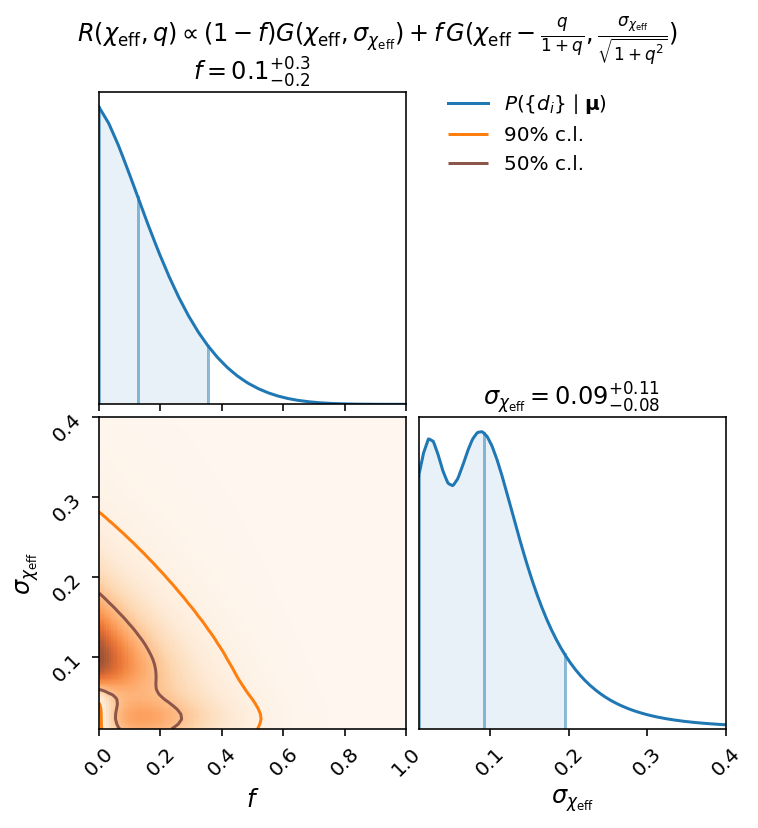

In [24]:
plt.clf();
for model in models:
    print(model.name)
    n_cols = n_rows = len(model.mu_params)
    for PCA in PSDs_coherences_approximants:
        fig, ax = plt.subplots(n_rows, n_cols, figsize=(2.7 * n_cols, 2.7 * n_rows + .5));
        if n_cols == 1: ax = [[ax]]
        plt.suptitle('{}'.format(model.latex), size='large')

        # Plot 2D likelihoods (off-diagonal in the plot grid)
        for row, y_par in list(enumerate(model.mu_params))[1:]:
            for col, x_par in list(enumerate(model.mu_params))[:row]:
                plt.sca(ax[row][col])
                xy_P = mu_igrid_2d[model.name, (x_par, y_par)]['P', (*PCA)].T

                plt.imshow(xy_P, extent=[*model.mu_bounds[x_par], *model.mu_bounds[y_par]],
                           cmap='Oranges', origin='lower', aspect='auto', alpha=.8)

                contours = plt.contour(mu_igrid_1d[model.name, x_par],
                                       mu_igrid_1d[model.name, y_par],
                                       xy_P,
                                       levels=levels[model.name, (*PCA), (x_par, y_par)],
                                       colors=['tab:orange', 'tab:brown'])
                for i in range(len(fractions)):
                    contours.collections[i].set_label('{:.0f}% c.l.'.format(100*fractions[i]))

        # Plot 1D likelihoods (diagonal)
        for i, mu_par in enumerate(model.mu_params):
            plt.sca(ax[i][i])
            for val in [median[model.name, (*PCA), mu_par], *bounds_estimate[model.name, (*PCA), mu_par]]:
                plt.plot([val]*2, [0, np.interp(val, mu_igrid_1d[model.name, mu_par],
                                                mu_igrid_1d[model.name, 'P', mu_par, (*PCA)])],
                          'C0', alpha=.5)
            span = np.linspace(*bounds_estimate[model.name, (*PCA), mu_par])
            plt.fill_between(span, 0, np.interp(span, mu_igrid_1d[model.name, mu_par],
                                                mu_igrid_1d[model.name, 'P', mu_par, (*PCA)]), alpha=.1)
            
            plt.title('{}$=${} {}'.format(
                latex[mu_par],
                latex_val_err(median[model.name, (*PCA), mu_par],
                              err_estimate[model.name, (*PCA), mu_par]),
                unit[mu_par].replace('(', '').replace(')','')))

            plt.plot(mu_igrid_1d[model.name, mu_par],
                     mu_igrid_1d[model.name, 'P', mu_par, (*PCA)], 
                     label=r'$P(\{d_i\} \mid \mathbf{\mu})$')

        # Embellish
        for col, x_par in enumerate(model.mu_params):
            ax[n_rows-1][col].set_xlabel(latex[x_par] + unit[x_par], size='large')
            if len(model.mu_params) > 1:
                plt.setp(ax[n_rows-1][col].get_xticklabels(), rotation=45)
            for row in range(n_rows-1):
                ax[row][col].tick_params(labelbottom='off')
        for row, y_par in list(enumerate(model.mu_params))[1:]:
            ax[row][0].set_ylabel(latex[y_par] + unit[y_par], size='large')
            if len(model.mu_params) > 1:
                plt.setp(ax[row][0].get_yticklabels(), rotation=45)
            for col in range(1, n_cols):
                ax[row][col].tick_params(labelleft='off')
        for row in range(n_rows-1):
            for col in range(row+1, n_cols):
                ax[row][col].axis('off')
        for col in range(n_cols):
            for row in range(1, n_rows):
                ax[0][col].get_shared_x_axes().join(ax[0][col], ax[row][col])
                ax[row][col].autoscale()
        for row in range(n_rows):
            for col in range(1, row):
                ax[row][0].get_shared_y_axes().join(ax[row][0], ax[row][col])
                ax[row][col].autoscale()
        for i in range(len(model.mu_params)):
            ax[i][i].tick_params(axis='y', left='off', labelleft='off')
            ax[i][i].set_ylim(ymin=0)
        ax[-1][-1].set_xlim(model.mu_bounds[model.mu_params[-1]])
        plt.tight_layout(rect=[0, 0, 1, 0.96]);
        plt.subplots_adjust(hspace=0.04, wspace=0.04);

        handles_1d, labels_1d = ax[0][0].get_legend_handles_labels()
        if len(model.mu_params) > 1:
            handles_2d, labels_2d = ax[1][0].get_legend_handles_labels()
            pos = ax[0][1].get_position()
            fig.legend(handles_1d + handles_2d, labels_1d + labels_2d, 
                       loc='upper left', bbox_to_anchor=(pos.x0, pos.y1), frameon=False)
        else:
            ax[0][0].legend(handles_1d, [r'$P(\{d_i\} \mid $'+latex[model.mu_params[0]]+'$)$'],
                            loc='best', frameon=False)

        plt.savefig('figures/{}_{}.pdf'.format(model.name, '_'.join(PCA)), bbox_inches='tight')

        plt.show()